In [1]:
import argparse
import os

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from synthetic_datasets import SineSyntheticDataset, BaseBERTTimeSeriesDataset

# from criterions import QuantileLoss
from configuration import get_attention_hparam_grid, make_attn_module_class, get_attention_names
# from sine_experiment import train, val_step, inference

In [21]:
from torch.utils.data import Dataset

class BaseBERTTimeSeriesDataset(Dataset):
    def __init__(
        self,
        X: torch.Tensor,
        fX: torch.Tensor,
        seq_len: int,
        pred_patch_len: int,
        n_pathes_per_sample: int
    ):
        """
        :param X: time steps (covariates)
        :param fX: features per time step
        :param seq_len: length of each sequence example in dataset
        :param pred_patch_len: size of the patches that are considered gaps in the samples
        """
        self.seq_len = seq_len
        self.pred_patch_len = pred_patch_len
        self.n_pathes_per_sample = n_pathes_per_sample
        self.X = X
        self.fX = fX
        self.mask = torch.tril(torch.ones((seq_len, seq_len)), diagonal=0)

    def __getitem__(self, index):
        
        cutoff = torch.randint(low=0, high=self.seq_len-self.pred_patch_len, size=(self.n_pathes_per_sample,))
        
        src_X = self.X[index : index + self.seq_len]
        src_fX = self.fX[index : index + self.seq_len].clone()
        
        tgt_X = src_X[cutoff: cutoff+self.pred_patch_len]
        tgt_fX = src_fX[cutoff: cutoff+self.pred_patch_len].clone()
        
        src_fX[cutoff: cutoff+self.pred_patch_len] = 0
        
        return src_X, src_fX, tgt_X, tgt_fX

    def __len__(self):
        return len(self.X) - self.seq_len

In [22]:
from basic_transformer import QuantileTransformer, QuantileConvDecoderOnlyTransformer
from criterions import QuantileLoss
import copy

def create_model(attention_module, config):
    return QuantileTransformer(
        d_in=2,
        n_quantiles=3,
        emb_size=config.emb_size,
        n_heads=config.n_heads,
        n_hidden=config.n_hidden,
        ffn_n_hidden=config.ffn_n_hidden,
        num_layers=1,
        _attention=attention_module,
        norm_first=True
    )


def train_step(model, criterion, train_dataloader, optimizer, device):
    model.train()
    train_loss = torch.zeros_like(criterion.q)
    n = 0
    # mask = mask.to(device)
    for sample in train_dataloader:
        src_X, src_fX, tgt_X, tgt_fX = (v.to(device) for v in sample)

        out = model(src_X, src_fX)
        p_loss = criterion(out[:, -tgt_X.shape[1]:], tgt_fX)

        optimizer.zero_grad()
        p_loss.sum().backward()
        optimizer.step()

        train_loss += p_loss * src_X.shape[0]
        n += src_X.shape[0]

    return train_loss / n


def val_step(model, criterion, val_dataloader, device):
    model.eval()
    val_loss = torch.zeros_like(criterion.q)
    n = 0
    # mask = mask.to(device)
    with torch.no_grad():
        for sample in val_dataloader:
            src_X, src_fX, tgt_X, tgt_fX = (v.to(device) for v in sample)

            out = model(src_X, src_fX)
            p_loss = criterion(out[:, -tgt_X.shape[1]:], tgt_fX)

            val_loss += p_loss * src_X.shape[0]
            n += src_X.shape[0]

    return val_loss / n


def format_print(loss: dict):
    return ', '.join([f"{p}:{l:.4f}" for p, l in loss.items()])

def train(attn_module, config, train_dl, val_dl, mask, verbose=False):
    model = create_model(attn_module, config).to(config.device)

    train_history = []
    val_history = []

    criterion = QuantileLoss(config).to(config.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    best_val_loss = float('inf')
    early_stopping_c = 0
    best_model = None

    for epoch in range(config.epochs):

        train_loss = train_step(model, criterion, train_dl, optimizer, config.device)
        train_history.append({'p10': train_loss[0].item(), 'p50': train_loss[1].item(), 'p90': train_loss[2].item()})

        val_loss = val_step(model, criterion, val_dl, config.device)
        val_history.append({'p10': val_loss[0].item(), 'p50': val_loss[1].item(), 'p90': val_loss[2].item()})

        if verbose: print(f"{epoch=}\t{format_print(train_history[-1])}\t{format_print(val_history[-1])}")

        val_loss_sum = val_loss.sum().item()
        scheduler.step(val_loss_sum)

        if val_loss_sum < best_val_loss:
            best_val_loss = val_loss_sum
            early_stopping_c = 0
            best_model = copy.deepcopy(model)
        else:
            early_stopping_c += 1

        if early_stopping_c > config.patience: break

    return best_model, train_history, val_history, best_val_loss

(torch.Size([200, 1]),
 torch.Size([200, 1]),
 torch.Size([50, 1]),
 torch.Size([50, 1]))

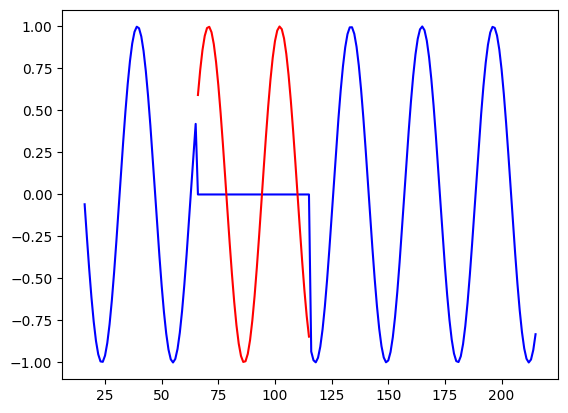

In [23]:
X = torch.arange(0, 10000, dtype=torch.float32).reshape(-1, 1)
fX = torch.sin(0.2 * X)

dataset = BaseBERTTimeSeriesDataset(
    X, fX,
    seq_len=200,
    pred_patch_len=50,
    n_pathes_per_sample=1
)

src_x, src_y, tgt_x, tgt_y = dataset[16]

plt.plot(src_x, src_y, 'b')
plt.plot(tgt_x, tgt_y, 'r')

src_x.shape, src_y.shape, tgt_x.shape, tgt_y.shape

In [24]:
train_set, test_set, val_set = torch.utils.data.random_split(dataset, (0.8, 0.1, 0.1))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=False, drop_last=True)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, drop_last=True)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(7840, 980, 980, 245, 15, 15)

In [33]:
attn_names = get_attention_names()

config = argparse.Namespace()
config.quantiles = [0.1, 0.5, 0.9]
config.lr = 1e-4
config.epochs = 200
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.patience = 20
config.attn_dropout = 0.1

config.emb_size = 20
config.n_heads = 4
config.n_hidden = 32
config.ffn_n_hidden = 2048

results = {}

for attn_name in attn_names[:1]:
    
    attn_hparam_grid = get_attention_hparam_grid(attn_name)
    attn_module_class = make_attn_module_class(attn_name)
    
    best_model = None
    best_val_loss = float('inf')
    best_attn_hparams = None
    best_train_history, best_val_history = None, None
    
    print(f'Starting training for attention module: {attn_name}')
    
    for attn_hparams in attn_hparam_grid:
        
        attn_hparams['dropout_rate'] = config.attn_dropout
        if attn_name == 'imp':
            attn_hparams['input_size'] = config.n_hidden // config.n_heads
        
        attn_module = attn_module_class(**attn_hparams)
        model, train_history, val_history, val_loss = train(attn_module, config, train_dl, val_dl, dataset.mask, verbose=True)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            best_attn_hparams = attn_hparams
            best_train_history = train_history
            best_val_history = val_history
            
        print(f'\t{attn_hparams=}, {val_loss=:.4f}, {best_val_loss=:.4f}')
    
    criterion = QuantileLoss(config).to(config.device)
    test_loss = val_step(best_model, criterion, test_dl, config.device).cpu()    
    results[attn_name] = {
        'attn_name': attn_name, 
        'test_loss': test_loss, 
        'best_model': best_model, 
        'best_attn_params': best_attn_hparams,
        'best_train_history': best_train_history, 
        'best_val_history': best_val_history
    }

Starting training for attention module: sdp
epoch=0	p10:0.1127, p50:0.3235, p90:0.1151	p10:0.0994, p50:0.3184, p90:0.0980
epoch=1	p10:0.1032, p50:0.3203, p90:0.1018	p10:0.0988, p50:0.3195, p90:0.0991
epoch=2	p10:0.1021, p50:0.3200, p90:0.1019	p10:0.0994, p50:0.3185, p90:0.0991
epoch=3	p10:0.1021, p50:0.3195, p90:0.1012	p10:0.0996, p50:0.3179, p90:0.0979
epoch=4	p10:0.1012, p50:0.3197, p90:0.1015	p10:0.0992, p50:0.3185, p90:0.0981
epoch=5	p10:0.1012, p50:0.3197, p90:0.1011	p10:0.0993, p50:0.3183, p90:0.0982
epoch=6	p10:0.1013, p50:0.3195, p90:0.1008	p10:0.0986, p50:0.3186, p90:0.0987
epoch=7	p10:0.1005, p50:0.3196, p90:0.1011	p10:0.0992, p50:0.3184, p90:0.0983
epoch=8	p10:0.1006, p50:0.3192, p90:0.1009	p10:0.0987, p50:0.3186, p90:0.0986
epoch=9	p10:0.1005, p50:0.3193, p90:0.1006	p10:0.0996, p50:0.3186, p90:0.0977
epoch=10	p10:0.1005, p50:0.3192, p90:0.1004	p10:0.0984, p50:0.3198, p90:0.0985
epoch=11	p10:0.1005, p50:0.3192, p90:0.1003	p10:0.0996, p50:0.3183, p90:0.0980
epoch=12	p10:0.100

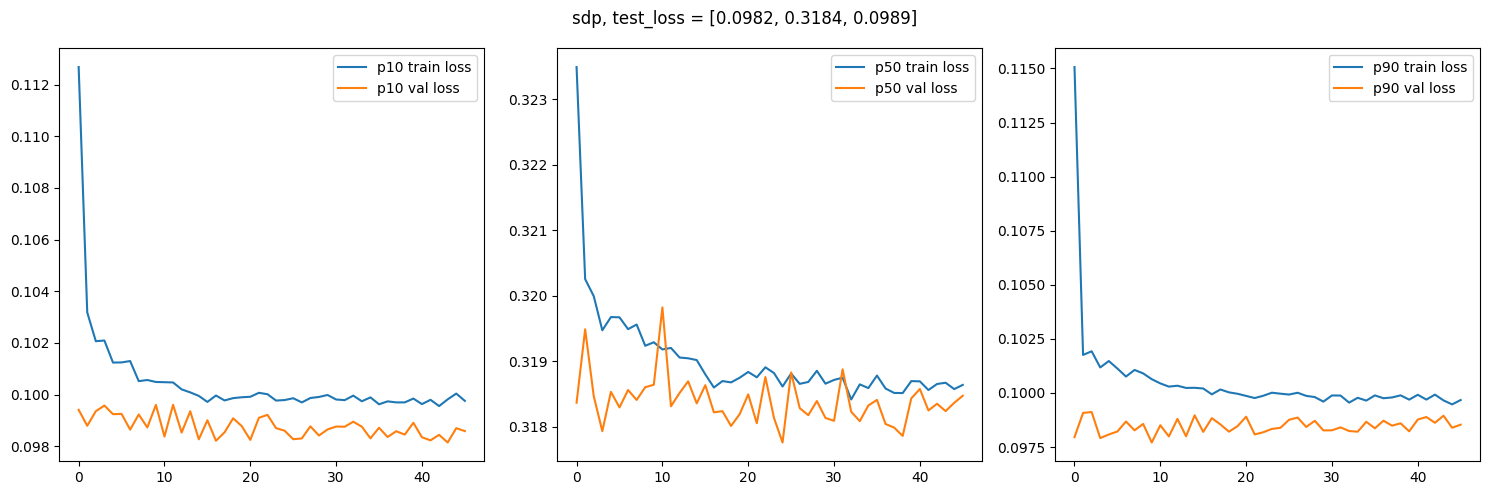

In [34]:
for name, exp in results.items():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
    
    train_history = exp['best_train_history']
    val_history = exp['best_val_history']
    
    p10_train = [x['p10'] for x in train_history]
    p50_train = [x['p50'] for x in train_history]
    p90_train = [x['p90'] for x in train_history]
    
    p10_val = [x['p10'] for x in val_history]
    p50_val = [x['p50'] for x in val_history]
    p90_val = [x['p90'] for x in val_history]
    
    ax1.plot(p10_train, label='p10 train loss')
    ax1.plot(p10_val, label='p10 val loss')
    ax1.legend()
    
    ax2.plot(p50_train, label='p50 train loss')
    ax2.plot(p50_val, label='p50 val loss')
    ax2.legend()
    
    ax3.plot(p90_train, label='p90 train loss')
    ax3.plot(p90_val, label='p90 val loss')
    ax3.legend()
    
    fig.suptitle(f'{exp["attn_name"]}, test_loss = {[round(q, 4) for q in exp["test_loss"].numpy()]}')
    
    plt.tight_layout()
    plt.show()

In [39]:
def inference(idx, best_model, test_set, config, attn_name):
    with torch.no_grad():
        src_X, src_fX, tgt_X, tgt_fX = test_set[idx]

        out = best_model(src_X.unsqueeze(0).to(config.device),
                         src_fX.unsqueeze(0).to(config.device))

        pred = out[:, -tgt_X.shape[0]:].squeeze().cpu()

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

        ax1.plot(src_X, src_fX, '-r', label="Source")
        ax1.plot(tgt_X, tgt_fX, '-b', label=f"Target")
        ax1.plot(tgt_X, pred[:, 1], '-g', label=f"Prediction")
        ax1.fill_between(tgt_X.squeeze(), pred[:, 0], pred[:, 2], alpha=0.2, color='green',
                         label=f"Prediction quantiles")
        ax1.axvline(src_X[-1, 0], linestyle='--', color='k')
        ax1.legend()

        attn_w = best_model.transformer_blocks[0].mha.attn_weights[0].cpu()
        for j, attn in enumerate(attn_w):
            ax2.plot(src_X, attn[-1], label=f"Attention head {j + 1}")
        ax2.axvline(src_X[-1, 0], linestyle='--', color='k')
        ax2.legend()

        ax1.set_title(f"Quantile Prediction for attention module: {attn_name}")
        ax2.set_title(f"Attention weights")

        plt.tight_layout()
        plt.show()

        fig, axes = plt.subplots(1, attn_w.shape[0], figsize=(5 * attn_w.shape[0], 5))
        fig.suptitle(f'Attention weight matrix visualization for module: {attn_name}')

        for j, (ax, attn) in enumerate(zip(axes, attn_w.cpu())):
            # t = torch.arange(attn.shape[0]).reshape(-1, 1)
            # attn = attn * t
            ax.imshow(attn)
            ax.set_title(f'Attention head {j + 1}')

        plt.show()

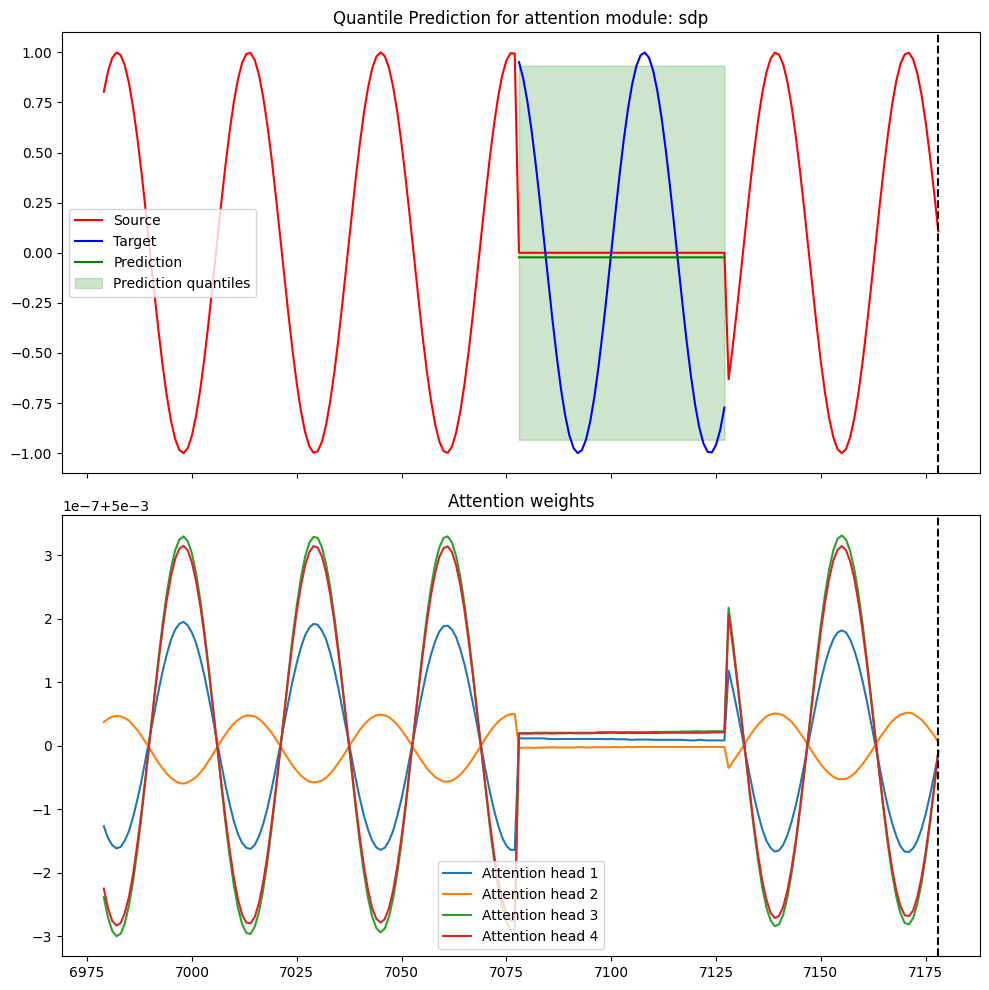

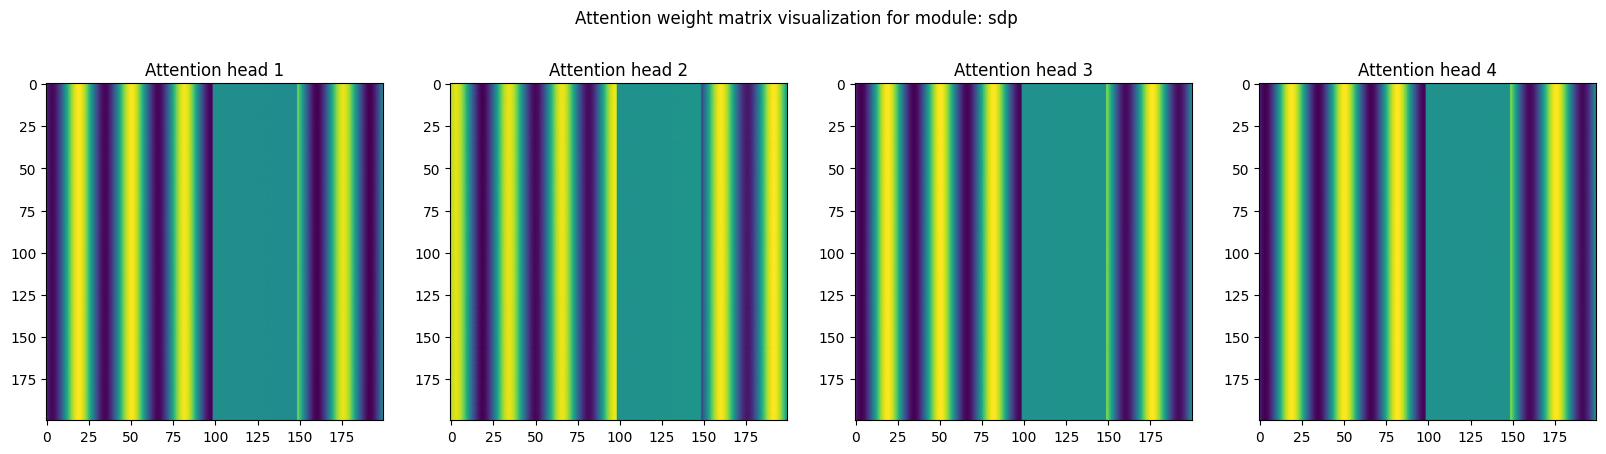

In [41]:
idx = 17

for name, exp in results.items():
    
    best_model = exp['best_model']
    attn_name = exp['attn_name']
    
    inference(idx, best_model, test_set, config, attn_name)

In [11]:
for name, exp in results.items():
    
    print(name, exp['test_loss'])

sdp tensor([0.0989, 0.3180, 0.0980])


In [62]:
results_path = os.path.join('results_sine_exp3')

os.makedirs(results_path, exist_ok=True)

In [63]:
for name, exp in results.items():
    ckpt = {
        'name': name, 
        'config': config, 
        'model': exp['best_model'].state_dict(), 
        'attn_name': exp['attn_name'], 
        'test_loss': exp['test_loss'], 
        'best_model': exp['best_model'], 
        'best_attn_params': exp['best_attn_params']
    }
    
    torch.save(ckpt, os.path.join(results_path, f'{name}_checkpoint.pt'))